In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,roc_auc_score, precision_recall_curve, roc_curve)
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Fraud.csv', low_memory=False)

In [3]:
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = df[col].astype('int32')

for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int32  
 1   type            str    
 2   amount          float32
 3   nameOrig        str    
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        str    
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int32  
 10  isFlaggedFraud  int32  
dtypes: float32(5), int32(3), str(3)
memory usage: 339.8 MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551136e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924048e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

In [10]:
for col in df.select_dtypes(include='object').columns:
    df[col].fillna("Unknown", inplace=True)

<Axes: xlabel='amount', ylabel='Count'>

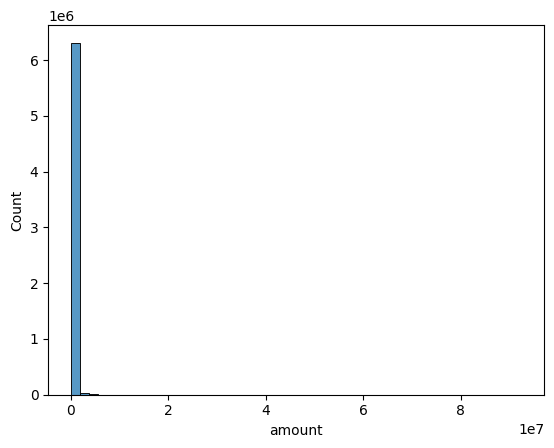

In [11]:
sns.histplot(df['amount'], bins=50)

In [12]:
df['amount'] = np.log1p(df['amount'])

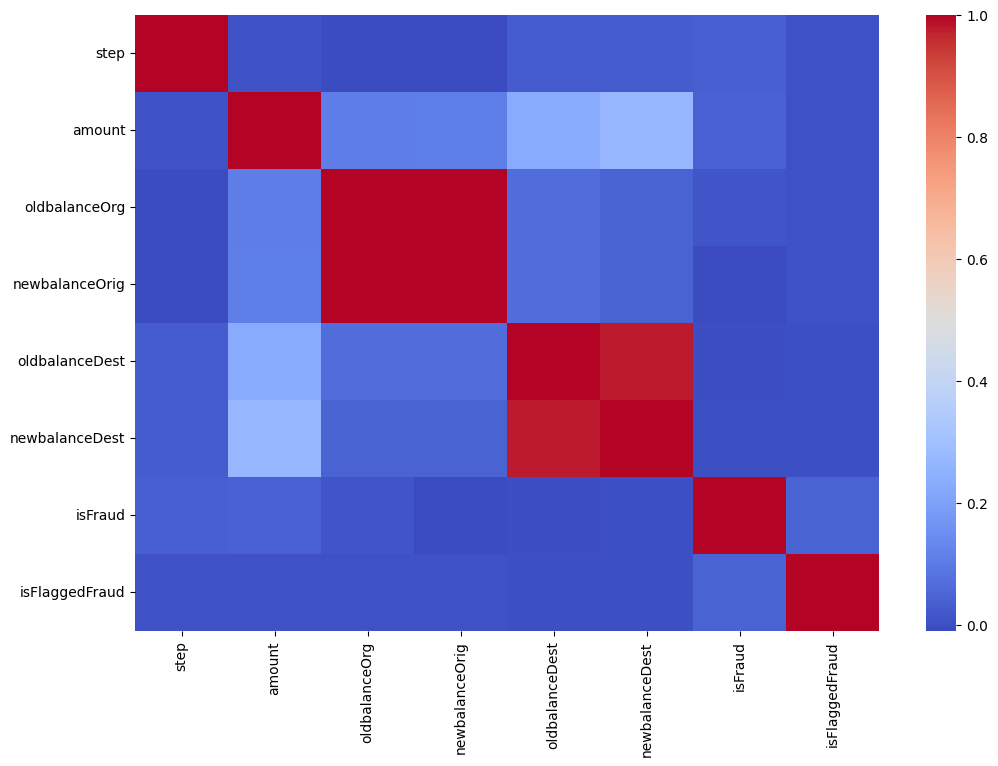

In [13]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

In [14]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category').cat.codes

In [15]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [17]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [18]:
print(X_train.shape)

(5090096, 10)


In [19]:
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(10)]
)

[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651247
[LightGBM] [Info] Start training from score -6.651247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [20]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:,1]

In [21]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93   1270881
           1       0.01      0.99      0.02      1643

    accuracy                           0.86   1272524
   macro avg       0.50      0.93      0.47   1272524
weighted avg       1.00      0.86      0.93   1272524



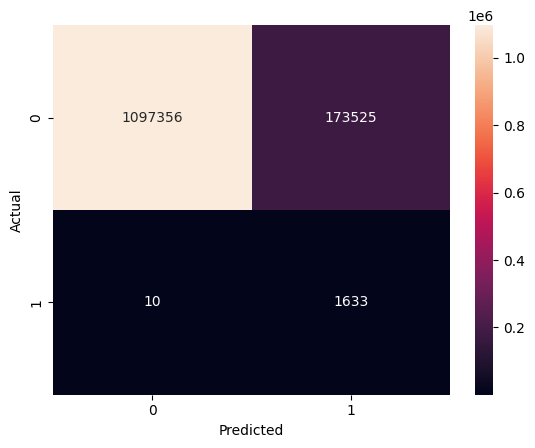

In [22]:
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", roc_auc)

ROC AUC: 0.9887090110344439


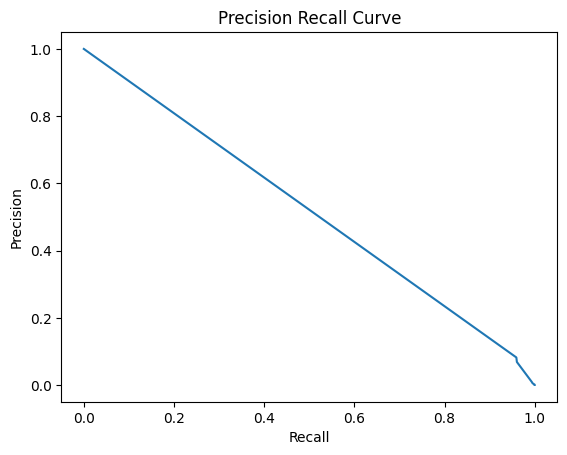

In [24]:
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.show()

In [25]:
best_threshold = thresholds[np.argmax(precision * recall)]
print("Best threshold:", best_threshold)

y_pred_opt = (y_prob > best_threshold).astype(int)
print(classification_report(y_val, y_pred_opt))

Best threshold: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.00      0.00      0.00      1643

    accuracy                           1.00   1272524
   macro avg       0.50      0.50      0.50   1272524
weighted avg       1.00      1.00      1.00   1272524



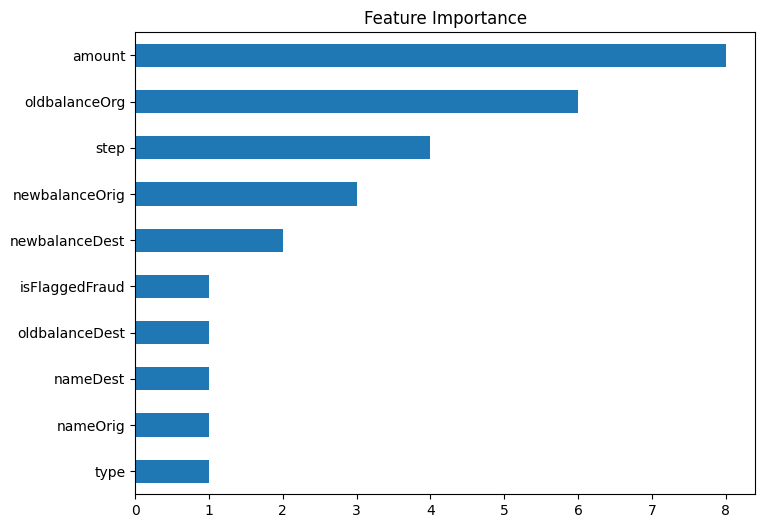

In [26]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance")
plt.show()

In [27]:
import shap

X_val_sample = X_val.sample(1000, random_state=42)

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_sample)

In [29]:
X_val_sample = X_val.sample(1000, random_state=42)

In [30]:
import joblib
joblib.dump(model, "fraud_model.pkl")

['fraud_model.pkl']